# 03 - Parse, Transform, and Pickle the reddit r/askscience comments

ACQUIRING REDDIT ASKSCIENCE JSON ARCHIVE

Before running this notebook, I used a thrid-party tool to download reddit/r/asksceicne content as JOSN files.  I acquired the JSON-ified reddit archive using the 'subredditarchive' tool, available on github at:

https://github.com/peoplma/subredditarchive
    
The subredditarchive tool was run over a few hours on my Macbook Pro to acquire ~ 2 GB JSON data, comprising about 80,000 files.  The JSON was about 380 MB after zip compression.  The complete record of reddit/asksciecne from 2012-2016 was downloaded.
   
_____________________________________________________

BUILDING PYTHON DICTIONARY OF REDDITORS AND COMMENTS   

This notebook recursively parses the JSON reccords to generate a python dictonary mapping redditors ('authors') to lists of their comments.  This dictionary is pickled and saved for later use.

I transferred the JSON files to an AWS instance and ran the code in this notebook there. 

### Imports

In [1]:
import json
from collections import defaultdict
import os
import numpy as np
import pickle
from sys import getsizeof
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pandas as pd
from copy import deepcopy
%matplotlib inline


In [2]:
### Function to parse reddit OP info ('Original Post').  Currently unused.

In [3]:
# For now, function does nothing
def parse_op (j):
    return None

### Functions to clean up the redditor text (same code used in processing abstracts)

In [4]:
def separate_sentences (s):
    s = re.sub('\.[a-zA-z]', lambda x: x.group(0)[0:-1] + ' ' + x.group(0)[-1], s)
    return s

def clean_text (s):
    try:
        s = filter (lambda x: x in string.printable, s) # Remove unprintable weirdness. NO ERR
        s = s.strip() #NO ERR
        s = separate_sentences (s)
    except:
        print '******* ERR'
        
    return s

### Recursive function to parse the comment tree

The reddit comment tree is a recursive JSON structure.  This function, called recursively, reads the comment tree and returns a dictionary mapping authors (redditors) to lists of all their comments in the document.  The function is originally called on a single reddit post, and then calls itself recursively as it navigates the comment tree.

In [5]:

# Helper function to build a dictionary containing body, body_length, score, and flair_text
# for a given comment.  
def build_comment_dict (body, score, flair_text, gilded):
    body = clean_text (body)
    r = {'BODY':body, 'BODY_LEN':len(body), 'SCORE':score, 'FLAIR_TEXT':flair_text, 'GILDED':gilded}
    return r

#######################################################################

# Function to parse the json for a reddit post.
# Recursive function -- it calls itself each time child posts are found.

# Thie return value, and the argument r, is a dictionary mapping authors
# to their comments.  The key is an author, and the values is LIST of
# DICTIONARIES.  Each dict in the list describes a single comment.  The 
# helper function build_comment_dict is called to produce
# the dictionary for a single comment.

#  NOTE -- this is the overall structure of the JSON doc tree:
#  rj[1]['data']['children'][0]['data']['replies']['data']['children']....

# Return value is a defaultdict
def parse_comment_tree (j, r = defaultdict(list), verbose=False):
    if verbose: print '\n### CALL TO parse_comment_tree ###'
    children = j['data']['children']
    
    for child in children:
        data = child['data']
        
        try:  #Sometimes the author field throws an error
            author = data['author']
            if verbose: print 'AUTHOR = ' + author

            body = data['body']
            if verbose: print 'BODY = ' + body[0:min(200, len(body))]

            score = data['score']
            flair_text = data['author_flair_text']
            gilded = data['gilded']

            if (not '[deleted]' in author) and (not '[deleted]' in body):
                comment_dict = build_comment_dict (body, score, flair_text, gilded) 
                r [author].append (comment_dict)
        except: pass
        
        try:
            if len (child['data']['replies']['data']['children']) > 0:
                r = parse_comment_tree (child['data']['replies'], r, verbose)
        except: pass
        
    return r

### Function to return total comments for each redditor

In [6]:
# Given the parsed json dictionary comment_dict, this function generates another dictionary
# mapping author name to the total number of comments they have written.

def get_n_comments_per_author (comment_dict):
    r = defaultdict(int)
    for k in comment_dict.keys():
        n_comments = len (comment_dict[k])
        r[k] = n_comments
    return r

### Function to limit reddit archive to those redditors that have written at least N comments

Also, extract only comment body text (no gilding info, upvote score, etc.)

In [7]:
def apply_n_comment_floor (comment_dict, n):
    r = defaultdict (list)
    for author in comment_dict.keys(): # loop on redditors
        if len (comment_dict[author]) >= n:
            #r [author] = [i['BODY'] for i in comment_dict[author]]
            r [author] = comment_dict[author]
    return r

### Function to build redditor dataframe, including SVD-transformed values for redditors

In [15]:
# From the redditor dictionary, build a dataframe with the following columns:
# AUTHOR
# NUMBER OF COMMENTS
# TOTAL GILDINGS
# AVG COMMENT LENGTH
# SVD Transform components for entire corpus of author's comments

def build_redditor_df (comment_dict, tfidf_obj, svd_obj, verbose = False):
    
    r = defaultdict(list)
    n = len (comment_dict.keys())
    text_concat_list = []  # Empty list.  Each element will be the total concatenated
                           # corpus of text for a single redditor.
    if verbose: print 'CONCATENATING AND CLENAING COMMENTS....'
    for i,k in enumerate (comment_dict.keys()):
        if verbose:
            if i%200 == 0: print 'AUTHOR ' + str (i) + ' OF ' + str (n)
        n_comments = len (comment_dict[k])
        avg_comment_len = np.mean ([len(i['BODY']) for i in comment_dict[k]])
        n_gildings = np.sum ([i['GILDED'] for i in comment_dict[k]])
        text_concat = '  '.join ([i['BODY'] for i in comment_dict[k]])
        text_concat = clean_text (text_concat)
        text_concat_list.append (text_concat)

        r['AUTHOR'].append (k)
        r['N_COMMENTS'].append (n_comments)
        r['AVG_COMMENT_LENGTH'].append (avg_comment_len)
        r['N_GILDINGS'].append (n_gildings)
        
    
    print 'PERFORMING TFIDF VECTORIZATION...'
    text_vec = tfidf_obj.transform (text_concat_list)
    print 'PERFORMING TRUNCATED SVD TRANSFORM....'
    text_svd = svd_obj.transform (text_vec)
    print text_svd.shape
    
    # Generate a list of 1d SVD arrays.  Each list element will be the 200-element np array,
    # corresponding to transformed corpus for one redditor
    svd_list =  [text_svd[i,:] for i in range (text_svd.shape[0])]
    r['SVD'] = svd_list
    df = pd.DataFrame (r)
    
    return df

## Main
### Parse comment JSON, build python comment dictonary, and pickle

In [9]:
#bp_pickles = '/home/ubuntu/KJK/pickles/reddit'
#bp_reddit_json = '/home/ubuntu/KJK/reddit_json_all'

bp_reddit_json = '/home/ubuntu/proj_asksci/files_in/ask_science_archive'
bp_pickles = '/home/ubuntu/proj_asksci/files_out/pickles'
fn_out = 'full_askreddit_archive.pkl'

# Create output directory, if not present
if not os.path.exists (bp_pickles): os.makedirs (bp_pickles)

# Get list of all the json files
fn_list = os.listdir(bp_reddit_json)
fn_list = filter (lambda x: x.lower()[-4:] == 'json', fn_list)

r = defaultdict(list)  # Build empty structure to accumulate the comment info
for i, fn in enumerate (fn_list):
    # Print every 5000th file, to monitor progress
    if i%5000 == 0: print 'PARSING FILE # ' + str (i) + ' OF ' + str(len(fn_list))  
    fp = os.path.join (bp_reddit_json, fn)
    with open (fp) as f:
        try:
            rj = json.load (f)
            op = parse_op (rj[0])  #rj[0] has information about the orginal post, discard for now
            r = parse_comment_tree (rj[1], r, verbose = False)
        except:
            print 'FAILURE IN LOADING OR READING FILE = ' + fn

with open (os.path.join (bp_pickles, fn_out), 'w') as f:
    pickle.dump (r, f)


PARSING FILE # 0 OF 80314
PARSING FILE # 5000 OF 80314
PARSING FILE # 10000 OF 80314
PARSING FILE # 15000 OF 80314
PARSING FILE # 20000 OF 80314
PARSING FILE # 25000 OF 80314
PARSING FILE # 30000 OF 80314
PARSING FILE # 35000 OF 80314
PARSING FILE # 40000 OF 80314
PARSING FILE # 45000 OF 80314
PARSING FILE # 50000 OF 80314
PARSING FILE # 55000 OF 80314
PARSING FILE # 60000 OF 80314
FAILURE IN LOADING OR READING FILE = t3_1r4ym5.json
PARSING FILE # 65000 OF 80314
PARSING FILE # 70000 OF 80314
PARSING FILE # 75000 OF 80314
PARSING FILE # 80000 OF 80314


TOTAL NUMBER OF REDDITORS = 181521
TOTAL NUMBER COMMENTS = 899699


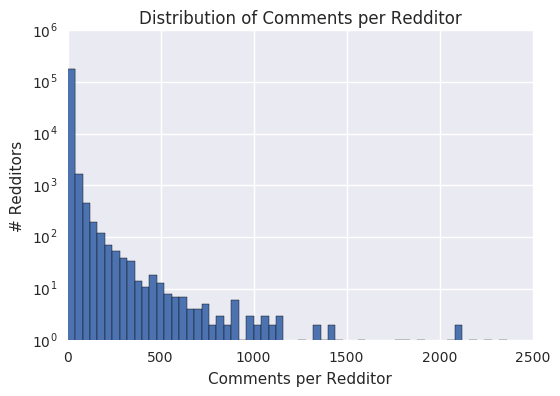

In [10]:
# Build a histogram to estimate the distribution of "prolific" redditors --
# This histogram gives the number of instances of redditors with
# 1-40 comments, 41-80 comments, etc. Note log scale.

# The vast majority of askscience redditors have written < 40 comments (leftmost bar)
n_comments_list = [len(i) for i in r.values()]
dummy = plt.hist (n_comments_list, bins = 60, range = (0,2400), log=True )
dummy = plt.ylabel('# Redditors')
dummy = plt.xlabel('Comments per Redditor')
dummy = plt.title ('Distribution of Comments per Redditor')

# Compute the total number of redditors and comments
print 'TOTAL NUMBER OF REDDITORS = ' + str(len(r.values()))
print 'TOTAL NUMBER COMMENTS = ' + str (sum (n_comments_list))


### Limit comment archive to "Prolific Redditors"

In [11]:
# Limit to redditors posting 40+ comments.  
r_prolific = apply_n_comment_floor (r, n=40)  
                                              
# Pickle the 'prolific archive'
with open (os.path.join (bp_pickles, 'prolific_ask_reddit_archive.pkl'), 'w') as f:
    pickle.dump (r_prolific, f)
    
# Compute the total number of comments in the "prolific archive"
# (About 40% of comments remain, despite disarding > 98% of authors)
total_n_comments = sum ([len(i) for i in r_prolific.values()])
print 'TOTAL NUMBER OF PROLIFIC REDDITORS = ' + str (len (r_prolific.values()))
print 'TOTAL NUMBER COMMENTS AMONG PROLIFIC REDDITORS = ' + str (total_n_comments)


TOTAL NUMBER OF PROLIFIC REDDITORS = 2753
TOTAL NUMBER COMMENTS AMONG PROLIFIC REDDITORS = 350160


### SVD Transformation of /r/askscience content
##### Finally, we will build a pandas dataframe that will be used in the Flask app to match a question to the best redditor, using the following steps:
    1)  For each prolific redditor, munge all their comments into a single long string.
    2)  Use the pickled SVD Transformer (from Notebook 04) to assign a 200-dimensional 'tag' to each redditors content.
    3)  Build a big pandas data frame with redditor, SVD-transformed tag, all content, and other miscellaneous info (gildings, etc.).  Pickle this for use by the flask app.

In [16]:
with open (os.path.join (bp_pickles, 'tfidf_obj.pkl')) as f:
    tfidf_obj = pickle.load (f)

with open (os.path.join (bp_pickles, 'TruncSVD_200_comp.pkl')) as f:
    svd_obj = pickle.load (f)
    
print 'Vectorizing and Transforming prolific redditor corpus...'
df = build_redditor_df (r_prolific, tfidf_obj, svd_obj, verbose = True)

with open (os.path.join (bp_pickles, 'df_redditors.pkl'), 'w') as f:
    print 'Pickling redditor dataframe...'
    %time pickle.dump (df, f)

Vectorizing and Transforming prolific redditor corpus...
CONCATENATING AND CLENAING COMMENTS....
AUTHOR 0 OF 2753
AUTHOR 200 OF 2753
AUTHOR 400 OF 2753
AUTHOR 600 OF 2753
AUTHOR 800 OF 2753
AUTHOR 1000 OF 2753
AUTHOR 1200 OF 2753
AUTHOR 1400 OF 2753
AUTHOR 1600 OF 2753
AUTHOR 1800 OF 2753
AUTHOR 2000 OF 2753
AUTHOR 2200 OF 2753
AUTHOR 2400 OF 2753
AUTHOR 2600 OF 2753
PERFORMING TFIDF VECTORIZATION...
PERFORMING TRUNCATED SVD TRANSFORM....
(2753, 200)
Pickling redditor dataframe...
CPU times: user 448 ms, sys: 16 ms, total: 464 ms
Wall time: 467 ms
